In [1]:
%matplotlib inline
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# easier access to tensorflow distributions
ds = tf.contrib.distributions

In [2]:
# expect dims (could be dynamic/None)
# possible to do batched evaluations
batch_dim = None
n_bins = 1
n_alpha_pars = 1
# shape nuisance parameters ([batch dim, n_alpha_pars])
alpha = tf.placeholder(dtype=tf.float32,shape=(batch_dim, n_alpha_pars),
                       name="alpha")
# expected nominal signal templates([n_bins])
sig_zero = tf.placeholder(dtype=tf.float32, shape=(n_bins,),
                          name="sig_zero")
# expected variation signal counts ([n_alpha_pars, n_bins])
sig_alpha_up = tf.placeholder(dtype=tf.float32, shape=(n_alpha_pars, n_bins),
                              name="sig_alpha_up")
sig_alpha_dw = tf.placeholder(dtype=tf.float32, shape=(n_alpha_pars, n_bins),
                              name="sig_alpha_dw")
# this tiled tensor will be useful for broadcasting later
alpha_tiled = tf.tile(alpha[:,:,tf.newaxis],[1,1,sig_zero.shape[0]])

In [3]:
# piecewise linear -- interpolation code 0 --
# variation wrt alpha (absolute var) for each nuissance
sig_alpha_linear_abs_var = tf.where(alpha_tiled< 0.,
    alpha_tiled*(sig_zero-sig_alpha_dw)[tf.newaxis],
    alpha_tiled*(sig_alpha_up-sig_zero)[tf.newaxis])
# sum over all alphas to get expected signal interpolated
sig_alpha_linear = sig_zero+tf.reduce_sum(sig_alpha_linear_abs_var, axis=1)

In [4]:
# piecewise exponential -- interpolation code 1 --
# variation wrt alpha (rel var) for each nuissance
sig_alpha_exp_rel_var = tf.where(alpha_tiled< 0.,
    tf.pow((sig_alpha_dw/sig_zero)[tf.newaxis],-alpha_tiled),
    tf.pow((sig_alpha_up/sig_zero)[tf.newaxis],alpha_tiled))
# prob over all to get expected signal interpolated
sig_alpha_exp = sig_zero*tf.reduce_prod(sig_alpha_exp_rel_var, axis=1)

In [5]:
# quadratic and linear-- interpolation code 2 --
# variation wrt alpha (absolute var) for each nuissance
sig_alpha_quad_a = 0.5*(sig_alpha_up+sig_alpha_dw)-sig_zero
sig_alpha_quad_b = 0.5*(sig_alpha_up-sig_alpha_dw)
sig_alpha_quad_switch = tf.where(alpha_tiled< 0.,
    tf.ones_like(alpha_tiled)*(sig_alpha_dw-sig_zero)[tf.newaxis],
    tf.ones_like(alpha_tiled)*(sig_alpha_up-sig_zero)[tf.newaxis])
sig_alpha_quad_abs_var = tf.where(tf.abs(alpha_tiled) > 1.,
    (2*sig_alpha_quad_b+tf.sign(alpha_tiled)*sig_alpha_quad_a)
        *(alpha_tiled-tf.sign(alpha_tiled))+sig_alpha_quad_switch,
    sig_alpha_quad_a*tf.pow(alpha_tiled,2)+sig_alpha_quad_b*alpha_tiled)   
# sum over all alphas to get expected signal interpolated
sig_alpha_quad = sig_zero+tf.reduce_sum(sig_alpha_quad_abs_var, axis=1)

In [6]:
# one bin, one alpha example
sig_alpha_up_arr = [[8.]]
sig_zero_arr = [6.]
sig_alpha_dw_arr = [[10.]]
alpha_arr = np.linspace(-2,2,21,
                        endpoint=True,dtype=np.float32)[np.newaxis].T

feed_dict = {sig_zero : sig_zero_arr,
             sig_alpha_up : sig_alpha_up_arr,
             sig_alpha_dw : sig_alpha_dw_arr,
             alpha : alpha_arr}

interps = [sig_alpha_linear, sig_alpha_exp, sig_alpha_quad]
interps_grads = [tf.gradients(interp, alpha) for interp in interps]

with tf.Session() as sess:
    interps_arr, interps_grads_arr = sess.run([interps,interps_grads], feed_dict=feed_dict)

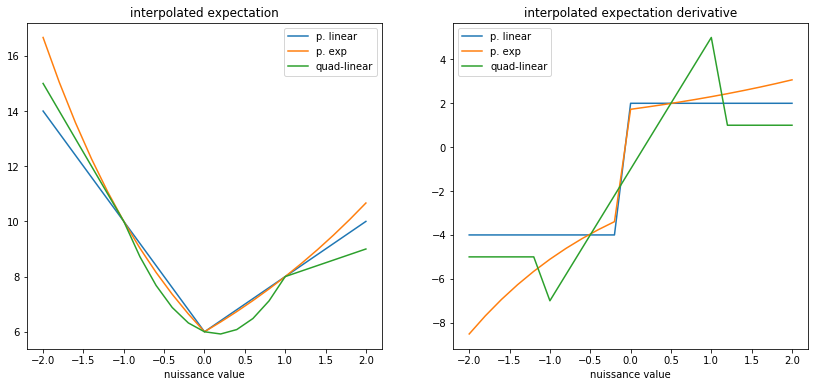

In [7]:
fig, axs = plt.subplots(1,2, figsize = (14,6))

interps_name = ["p. linear", "p. exp", "quad-linear" ]

for interp_arr, interp_name in zip(interps_arr, interps_name):
    axs[0].plot(alpha_arr, interp_arr, label=interp_name)

axs[0].set_title("interpolated expectation")
axs[0].set_xlabel("nuissance value")
axs[0].legend()
    
for interp_grad_arr, interp_name in zip(interps_grads_arr, interps_name):
    axs[1].plot(alpha_arr, interp_grad_arr[0], label=interp_name)

axs[1].set_title("interpolated expectation derivative")
axs[1].set_xlabel("nuissance value")
axs[1].legend()

fig;